In [1]:
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn

In [2]:
from models.backbone import Backbone
from models.encoder import EncoderModule
from models.joiner import Joiner
from models.losses import Attention_penalty_factor

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
H = 180
W=180

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

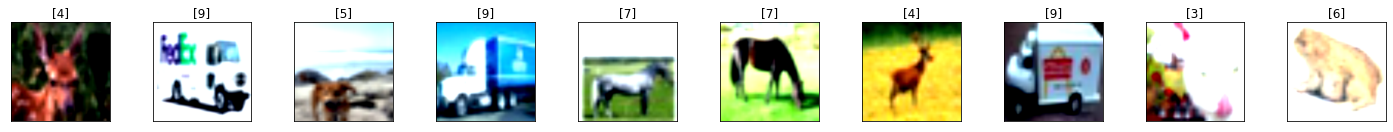

In [7]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [8]:
backbone = Backbone().to(device)
encoder = EncoderModule().to(device)
model = Joiner(backbone, encoder, hidden_dim=512, image_h=H, image_w=W)

In [9]:
model = model.to(device)

In [10]:
#TESTING MODEL ON A SINGLE IMAGE

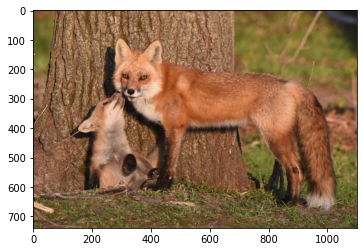

In [11]:
url = 'https://ogden_images.s3.amazonaws.com/www.timesrepublican.com/images/2019/05/02231710/Fox-WEB-1100x739.jpg'

im = Image.open(requests.get(url, stream=True).raw)
plt.plot()
plt.imshow(im)

In [12]:
img = transform(im).unsqueeze(0)
print("Input shape:", img.shape)

Input shape: torch.Size([1, 3, 180, 180])


In [13]:
outputs, att, sattn, f_map, pos, pattn = model(img)

In [14]:
print("Output shape:", outputs.shape)
print("Feature Map shape:", f_map.shape)
print("Attention Maps shape:", sattn.shape)
print("Encoder output shape:", att.shape)
print("Positional Encoding shape:", pos.shape)

Output shape: torch.Size([1, 10])
Feature Map shape: torch.Size([1, 512, 12, 12])
Attention Maps shape: torch.Size([1, 12, 12, 12, 12])
Encoder output shape: torch.Size([1, 512, 12, 12])
Positional Encoding shape: torch.Size([1, 512, 12, 12])


In [15]:
#Training Model

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [17]:
epochs = 2
running_loss_history = [] # training loss - to generate a plot
running_corrects_history = [] # traning accuracy
val_running_loss_history = [] # validation loss
val_running_corrects_history = [] # validation accuracy

for e in range(epochs):
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:
    #TRAINING
        inputs = inputs.to(device) # allow gpu use
        labels = labels.to(device) # allow gpu use
        outputs, att, sattn, f_map, pos, pattn = model(inputs) #gives the output of the last layer
        loss = criterion(outputs, labels) # comparing outputs and labels using the criteria

        optimizer.zero_grad() #zero the grad
        loss.backward() #backpropagation
        optimizer.step() #optimize weights 

        _, preds = torch.max(outputs, 1) # return the index of the maximum value predicted for that image (used to generate the accuracy)
        running_loss += loss.item() # the sum of the loss of all itens
        running_corrects += torch.sum(preds == labels.data) # the sum of correct prediction on an epochs

    else:
        #VALIDATION
        with torch.no_grad(): # to save memory (temporalely set all the requires grad to be false)
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device) # allow gpu use
                val_labels = val_labels.to(device) # allow gpu use
                val_outputs, att, sattn, f_map, pos, pattn = model(val_inputs) #passes the image through the network and get the output
                val_loss = criterion(val_outputs, val_labels) #compare output and labels to get the loss 

                _, val_preds = torch.max(val_outputs, 1) #same as for training
                val_running_loss += val_loss.item() #same as for training
                val_running_corrects += torch.sum(val_preds == val_labels.data) #same as for training

    #TRAINING LOSS AND ACCURACY
    epoch_loss = running_loss/len(training_loader) # the sum of the loss of all itens divided by the number of itens
    epoch_acc = running_corrects.float()/ len(training_loader) # the sum of correct predictions divided by the number of itens
    running_loss_history.append(epoch_loss) #append to respective list
    running_corrects_history.append(epoch_acc) #append to respective list

    #VALIDATION LOSS AND ACCURACY
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss) #append to respective list
    val_running_corrects_history.append(val_epoch_acc) #append to respective list
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

KeyboardInterrupt: 